## Imports

In [1]:
import json
import sys
from ast import literal_eval

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

sys.path.append('..')
from const import *

## Support Functions

In [2]:
def compute_bins2(arr, arr2, breaks):
    densities = []
    bins = []
    for i in range(len(breaks)):
        temp = []
        for j, value in enumerate(arr):
            if i == 0:
                if value <= breaks[i]:
                    temp.append(arr2[j])
            else:
                if (value <= breaks[i]) & (value > breaks[i-1]):
                    temp.append(arr2[j])
        if temp:
            densities.append(len(temp)/len(repo_names))
            bins.append(temp)
    return breaks, bins, densities

## Overall Statistic

In [3]:
# load pull request data that contain vulnerabilities
pr_vuln = pd.read_csv(CSV_DATA['pr_vulnerabilities'], index_col=False)
pr_vuln['severities'] = pr_vuln['severities'].apply(literal_eval)

rejected_prs = sum(pr_vuln['state'] == 'CLOSED')
merged_prs = sum(pr_vuln['state'] == 'MERGED')
num_projects = len(pr_vuln.groupby('repository').count())

print('Pull request statistics')
print('total: {}'.format(len(pr_vuln.index)))
print('')
print('projects: {}'.format(num_projects))
print('')
print('open: '+str(sum(pr_vuln['state'] == 'OPEN'))+' ('+str((sum(pr_vuln['state'] == 'OPEN')/len(pr_vuln))*100)+')')
print('closed: '+str(sum(pr_vuln['state'] == 'CLOSED'))+' ('+str((sum(pr_vuln['state'] == 'CLOSED')/len(pr_vuln))*100)+')')
print('')
print('rejected: '+str(rejected_prs)+' ('+str(rejected_prs/sum(pr_vuln['state'] != 'OPEN')*100)+')')
print('merged: '+str(merged_prs)+' ('+str(merged_prs/sum(pr_vuln['state'] != 'OPEN')*100)+')')


Pull request statistics
total: 4416

projects: 978

open: 221 (5.004528985507246)
closed: 1804 (40.85144927536232)

rejected: 1804 (43.00357568533969)
merged: 2391 (56.99642431466031)


In [4]:
from datetime import datetime, timezone

def get_time_chunk(timestr):
    datestr = pd.to_datetime(timestr)
    if datestr>=pd.to_datetime('2019-06-01',utc=True) and datestr<pd.to_datetime('2019-10-01',utc=True):
        return 'P1'
    elif datestr>=pd.to_datetime('2019-10-01',utc=True) and datestr<pd.to_datetime('2020-02-01',utc=True):
        return 'P2'
    elif datestr>=pd.to_datetime('2020-02-01',utc=True):
        return 'P3'

## Merge Rate Analysis

In [5]:
# load the names (GitHub slugs) of the selected repositories
repo_names = pd.read_csv(CSV_DATA['dependabot_filtered_repos'], index_col=False)['repository'].tolist()

In [6]:
projects_with_closed = []
merged = []
total = []
ratio = []

dfdetailed = pd.DataFrame()

for repo_name in repo_names:
    if repo_name not in pr_vuln.repository.unique().tolist():
        continue
    with open(os.path.join(JSON_DATA['security_updates'], repo_name.replace('/', '@') + '.json'), 'r', encoding='utf-8') as json_file:
        prs = json.load(json_file)
        closed_prs = 0
        open_prs = 0
        merged_prs = 0
        for pr in prs:
            if pr['state'] == 'CLOSED':
                closed_prs += 1
            elif pr['state'] == 'OPEN':
                open_prs += 1
            elif pr['state'] == 'MERGED':
                merged_prs += 1
            dfdetailed = dfdetailed.append({
                'repository':repo_name,
                'created_at':pr['createdAt'],
                'status':pr['state']
            },ignore_index=True)
                
        if closed_prs + merged_prs:
            projects_with_closed.append(repo_name)
            merged.append(merged_prs)
            total.append(merged_prs + closed_prs)
            ratio.append(merged_prs/(merged_prs + closed_prs))
        
            

/tmp/ipykernel_2385325/4081260727.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfdetailed = dfdetailed.append({
/tmp/ipykernel_2385325/4081260727.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfdetailed = dfdetailed.append({
/tmp/ipykernel_2385325/4081260727.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfdetailed = dfdetailed.append({
/tmp/ipykernel_2385325/4081260727.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfdetailed = dfdetailed.append({
/tmp/ipykernel_2385325/4081260727.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat

In [7]:
dfdetailed.head()

,repository,created_at,status
0,b2wads/grimorio-ui,2019-10-10T19:21:58Z,CLOSED
1,b2wads/grimorio-ui,2020-01-06T16:47:21Z,MERGED
2,idena-network/idena-desktop,2019-06-29T11:57:09Z,MERGED
3,idena-network/idena-desktop,2019-07-15T13:01:58Z,MERGED
4,idena-network/idena-desktop,2019-09-11T10:02:08Z,CLOSED


In [8]:
dfdetailed['period'] = dfdetailed.apply(lambda x:get_time_chunk(x['created_at']),axis=1)
dfdetailed = dfdetailed.drop(columns=['created_at'])
dfdetailed.head(2)

,repository,status,period
0,b2wads/grimorio-ui,CLOSED,P2
1,b2wads/grimorio-ui,MERGED,P2


In [9]:
dfdetailed = pd.merge(
    dfdetailed,
    dfdetailed.groupby('repository')['status'].count().reset_index().rename(index=str,columns={'status':'count'}),
    on='repository',
    how='inner'
)
dfdetailed.head(2)

,repository,status,period,count
0,b2wads/grimorio-ui,CLOSED,P2,2
1,b2wads/grimorio-ui,MERGED,P2,2


In [10]:
def get_categorical(prs):
    if prs>=1 and prs<=2:
        return '[1,2]'
    elif prs>=3 and prs<=4:
        return '[3,4]'
    elif prs>=5 and prs<=10:
        return '[5,10]'
    elif prs>=11 and prs<=67:
        return '[11,67]'

dfdetailed['category'] = dfdetailed.apply(lambda x: get_categorical(x['count']), axis=1)
dfdetailed.head(2)

,repository,status,period,count,category
0,b2wads/grimorio-ui,CLOSED,P2,2,"[1,2]"
1,b2wads/grimorio-ui,MERGED,P2,2,"[1,2]"


C:\Users\eleni\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


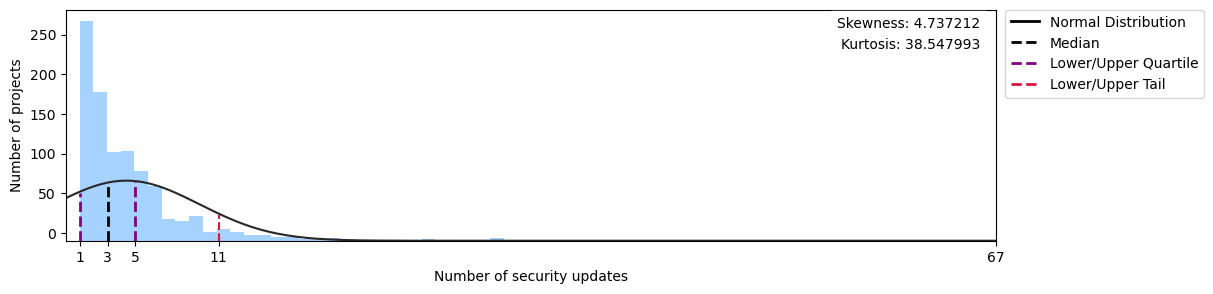

In [14]:
from scipy.stats import norm
from matplotlib.lines import Line2D

plt.rcParams["figure.figsize"] = (12,3)
ax = sns.distplot(total, bins = 67, color="dodgerblue", fit=norm, kde=False, norm_hist=True)
ax.text(x=0.983, y=0.97, transform=ax.transAxes, s="Skewness: %f" % stats.skew(total),
        fontsize=10, verticalalignment='top', horizontalalignment='right',
        backgroundcolor='white', color='black')
ax.text(x=0.983, y=0.88, transform=ax.transAxes, s="Kurtosis: %f" % stats.kurtosis(total, fisher=False),
        fontsize=10, verticalalignment='top', horizontalalignment='right',
        backgroundcolor='white', color='black')
ax.set_xlim([0,67])
ax.set_yticks([0.01, 0.06, 0.11, 0.16, 0.21, 0.26])
ax.set_yticklabels([0, 50, 100, 150, 200, 250])
quantiles = stats.mstats.mquantiles(total)
ax.set_ylabel('Number of projects')
ax.set_xlabel('Number of security updates')
ax.vlines(quantiles[1], 0, ax.lines[0].get_ydata()[int(quantiles[1])+12], color='black', ls='--',linewidth=2.0)
ax.vlines(quantiles[0], 0, ax.lines[0].get_ydata()[int(quantiles[0])+9], color='purple', ls='--',linewidth=2.0)
ax.vlines(quantiles[2], 0, ax.lines[0].get_ydata()[int(quantiles[2])+17], color='purple', ls='--',linewidth=2.0)
ax.vlines(quantiles[2] + 1.5*(quantiles[2]-quantiles[0]), 0, 0.033, color='crimson', ls='--')
ax.set_xticks([quantiles[0], quantiles[1], quantiles[2], quantiles[2] + 1.5*(quantiles[2]-quantiles[0]), max(total)])
custom_lines = [Line2D([0], [0], color='black', lw=2),
                Line2D([0], [0], color='black', ls='--', lw=2),
                Line2D([0], [0], color='purple', ls='--', lw=2),
                Line2D([0], [0], color='crimson', ls='--', lw=2)]
lgd = ax.legend(custom_lines, ['Normal Distribution', 'Median', 'Lower/Upper Quartile', 'Lower/Upper Tail'],
                bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
plt.savefig('RQ1-distribution.png', dpi=600, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [15]:
breaks, bins, densities = compute_bins2(total, ratio, [2, 4, 10, 67])
plt.rcParams["figure.figsize"] = (20,5)
number_of_prs = []
merge_rates = []
periods = []
for i, value in enumerate(breaks):
    if i == 0:
        for j in bins[i]:
            number_of_prs.append('[1,' + str(int(value)) + ']')
            merge_rates.append(j)
    else:
        if value - breaks[i-1] > 1:
            for j in bins[i]:
                number_of_prs.append('[' + str(int(breaks[i-1]) + 1) + ',' + str(int(value)) + ']')
                merge_rates.append(j)
        else:
            for j in bins[i]:
                number_of_prs.append(str(int(value)))
                merge_rates.append(j)
df = pd.DataFrame({'#_security_updates': number_of_prs, 'merge_ratio': merge_rates})
df.head()

,#_security_updates,merge_ratio
0,"[1,2]",0.5
1,"[1,2]",0.0
2,"[1,2]",0.0
3,"[1,2]",0.0
4,"[1,2]",0.0


In [16]:
df2 = df.copy()
df2['merge_ratio'] = df2['merge_ratio']*100
groupedstats= df.groupby('#_security_updates').describe().reset_index().round(2)
groupedstats

#_security_updates merge_ratio                                        
                           count  mean   std  min   25%   50%   75%  max
0              [1,2]       441.0  0.49  0.47  0.0  0.00  0.50  1.00  1.0
1            [11,67]        72.0  0.61  0.38  0.0  0.26  0.78  0.94  1.0
2              [3,4]       213.0  0.59  0.43  0.0  0.00  0.75  1.00  1.0
3             [5,10]       236.0  0.57  0.42  0.0  0.00  0.80  1.00  1.0

In [11]:
st0 = pd.merge(
    dfdetailed[dfdetailed['status']=='MERGED'].groupby(by=['category','repository'])['status'].count().reset_index().rename(index=str,columns={'status':'merged'}),
    dfdetailed[dfdetailed['status']!='OPEN'].groupby(by=['category','repository'])['status'].count().reset_index().rename(index=str,columns={'status':'total'}),
    on=['category','repository'],
    how='outer'
)
st0['merged'] = st0['merged'].fillna(0)
st0['ratio'] = st0['merged']/st0['total']
st0.sort_values(by='ratio')

,category,repository,merged,total,ratio
961,"[5,10]",wu-yu-xuan/blog.mscorlib.top,0.0,2,0.0
753,"[1,2]",mdbootstrap/React-Bootstrap-with-Material-Design,0.0,1,0.0
754,"[1,2]",medialab/website,0.0,2,0.0
755,"[1,2]",microsoft/pxt-blockly,0.0,1,0.0
756,"[1,2]",mika-cn/maoxian-web-clipper,0.0,1,0.0
...,...,...,...,...,...
375,"[3,4]",codypearce/material-bread,4.0,4,1.0
376,"[3,4]",common-voice/sentence-collector,3.0,3,1.0
379,"[3,4]",dekdevy/hordes-loc,3.0,3,1.0
382,"[3,4]",ecency/ecency-mobile,4.0,4,1.0


In [12]:
st0.groupby('category')['ratio'].describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
"[1,2]",418.0,0.519139,0.465467,0.0,0.000000,0.500000,1.000000,1.0
"[11,67]",75.0,0.605860,0.384531,0.0,0.254032,0.777778,0.930952,1.0
"[3,4]",220.0,0.559848,0.436278,0.0,0.000000,0.666667,1.000000,1.0
"[5,10]",249.0,0.549616,0.424922,0.0,0.000000,0.666667,1.000000,1.0


In [17]:
groupedstats

#_security_updates merge_ratio                                        
                           count  mean   std  min   25%   50%   75%  max
0              [1,2]       441.0  0.49  0.47  0.0  0.00  0.50  1.00  1.0
1            [11,67]        72.0  0.61  0.38  0.0  0.26  0.78  0.94  1.0
2              [3,4]       213.0  0.59  0.43  0.0  0.00  0.75  1.00  1.0
3             [5,10]       236.0  0.57  0.42  0.0  0.00  0.80  1.00  1.0

In [28]:
st2 = pd.merge(
    dfdetailed[dfdetailed['status']=='MERGED'].groupby(by=['category','repository','period'])['status'].count().reset_index().rename(index=str,columns={'status':'merged'}),
    dfdetailed[dfdetailed['status']!='OPEN'].groupby(by=['category','repository','period'])['status'].count().reset_index().rename(index=str,columns={'status':'total'}),
    on=['category','repository','period'],
    how='outer'
)
st2['merged'] = st2['merged'].fillna(0)
st2['ratio'] = st2['merged']/st2['total']
st2.sort_values(by='ratio')

,category,repository,period,merged,total,ratio
1542,"[5,10]",wu-yu-xuan/blog.mscorlib.top,P2,0.0,2,0.0
1184,"[1,2]",streamr-dev/broker,P3,0.0,1,0.0
1183,"[1,2]",streamr-dev/broker,P2,0.0,1,0.0
1182,"[1,2]",sparkdesignsystem/spark-design-system,P1,0.0,2,0.0
1181,"[1,2]",shockpkg/packages,P3,0.0,1,0.0
...,...,...,...,...,...,...
560,"[3,4]",keyboardio/Chrysalis,P3,3.0,3,1.0
559,"[3,4]",kenrick95/twinkle,P3,1.0,1,1.0
558,"[3,4]",kenrick95/twinkle,P1,2.0,2,1.0
566,"[3,4]",lidaof/eg-react,P1,3.0,3,1.0


In [29]:
st2.groupby(by=['period','category'])['ratio'].describe()

count      mean       std  min       25%       50%  75%  max
period category                                                              
P1     [1,2]      84.0  0.666667  0.461358  0.0  0.000000  1.000000  1.0  1.0
       [11,67]    43.0  0.711982  0.343215  0.0  0.500000  0.875000  1.0  1.0
       [3,4]      93.0  0.818100  0.349893  0.0  1.000000  1.000000  1.0  1.0
       [5,10]    133.0  0.753345  0.372568  0.0  0.666667  1.000000  1.0  1.0
P2     [1,2]     160.0  0.500000  0.495261  0.0  0.000000  0.500000  1.0  1.0
       [11,67]    64.0  0.576934  0.437811  0.0  0.000000  0.825758  1.0  1.0
       [3,4]     137.0  0.451946  0.466803  0.0  0.000000  0.250000  1.0  1.0
       [5,10]    187.0  0.508208  0.476935  0.0  0.000000  0.500000  1.0  1.0
P3     [1,2]     261.0  0.507663  0.488265  0.0  0.000000  0.500000  1.0  1.0
       [11,67]    58.0  0.580084  0.445681  0.0  0.000000  0.750000  1.0  1.0
       [3,4]     144.0  0.600694  0.470257  0.0  0.000000  1.000000  1.0  1.0
       [5,10]    179.0  0.573645  0.458741  0.0  0.000000  0.800000  1.0  1.0

In [30]:
groupedstats

#_security_updates merge_ratio                                        
                           count  mean   std  min   25%   50%   75%  max
0              [1,2]       441.0  0.49  0.47  0.0  0.00  0.50  1.00  1.0
1            [11,67]        72.0  0.61  0.38  0.0  0.26  0.78  0.94  1.0
2              [3,4]       213.0  0.59  0.43  0.0  0.00  0.75  1.00  1.0
3             [5,10]       236.0  0.57  0.42  0.0  0.00  0.80  1.00  1.0

In [31]:
filtered2 = st2.groupby('repository')['period'].nunique().reset_index()
print(len(filtered2))
filtered2 = filtered2[filtered2['period']>=3]
print(len(filtered2))
filtered2.head()

962
100


,repository,period
3,30-seconds/30-seconds-of-code,3
4,ACM-UCI/ACM-UCI-Website,3
11,Adslot/adslot-ui,3
12,AlexsLemonade/refinebio-frontend,3
15,ArcBlock/forge-js,3


In [32]:
st2 = st2[st2['repository'].isin(filtered2.repository.unique().tolist())]

In [33]:
st2.groupby(by=['period','category'])['ratio'].describe()

count      mean       std  min       25%  50%  75%  max
period category                                                         
P1     [11,67]    25.0  0.724160  0.346695  0.0  0.500000  0.9  1.0  1.0
       [3,4]      14.0  0.714286  0.425815  0.0  0.500000  1.0  1.0  1.0
       [5,10]     61.0  0.778884  0.368487  0.0  0.666667  1.0  1.0  1.0
P2     [11,67]    25.0  0.636111  0.452189  0.0  0.000000  1.0  1.0  1.0
       [3,4]      14.0  0.642857  0.497245  0.0  0.000000  1.0  1.0  1.0
       [5,10]     61.0  0.732240  0.442299  0.0  0.000000  1.0  1.0  1.0
P3     [11,67]    25.0  0.738254  0.364530  0.0  0.500000  1.0  1.0  1.0
       [3,4]      14.0  0.678571  0.464391  0.0  0.125000  1.0  1.0  1.0
       [5,10]     61.0  0.703357  0.424575  0.0  0.333333  1.0  1.0  1.0

In [15]:
for period in sorted(pr_vuln.period.unique().tolist()):
    pr_period = pr_vuln[pr_vuln['period']==period]
    
    break

In [9]:
#Total statistics
df2['merge_ratio'].describe().reset_index().round(2)

,index,merge_ratio
0,count,962.00
1,mean,54.31
2,std,44.27
3,min,0.00
4,25%,0.00
5,50%,66.67
6,75%,100.00
7,max,100.00


## Statistical Analysis

In [10]:
from scipy.stats import mannwhitneyu

df = df.rename(index=str,columns={'#_security_updates':'group'})

pvalues = pd.DataFrame()

categories = df.group.unique()

for i in range(0,len(categories)):
    for j in range(i,len(categories)):
        if i==j:
            continue
        
        group1 = categories[i]
        group2 = categories[j]
        stat, p = mannwhitneyu(df[df['group']==group1].merge_ratio.values.tolist(), 
                               df[df['group']==group2].merge_ratio.values.tolist())
        
        pvalues = pvalues.append({
            'group1':group1,
            'group2':group2,
            'pvalue':p
        },ignore_index=True)

pvalues

C:\Users\eleni\AppData\Local\Temp\ipykernel_13240\2813350299.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pvalues = pvalues.append({
C:\Users\eleni\AppData\Local\Temp\ipykernel_13240\2813350299.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pvalues = pvalues.append({
C:\Users\eleni\AppData\Local\Temp\ipykernel_13240\2813350299.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pvalues = pvalues.append({
C:\Users\eleni\AppData\Local\Temp\ipykernel_13240\2813350299.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pvalues = pvalues.append({
C:\Users\eleni\AppData\Local\Temp\ipykernel_13240\2813350299.py:19: FutureWarnin

,group1,group2,pvalue
0,"[1,2]","[3,4]",0.025250
1,"[1,2]","[5,10]",0.100049
2,"[1,2]","[11,67]",0.328718
3,"[3,4]","[5,10]",0.620962
4,"[3,4]","[11,67]",0.544996
5,"[5,10]","[11,67]",0.975924


In [11]:
#Bonferroni correction for multiple comparisons
import statsmodels.stats.multitest as smt

bonfresults = smt.multipletests(
            pvalues.pvalue.values.tolist(),
            alpha=0.05,
            method='bonferroni')

pvalues['corrected_pvalue'] = bonfresults[1]

newthres = bonfresults[3]

pvalues['rejectH0'] = pvalues.apply(lambda x: True if x['corrected_pvalue']<newthres else False , axis=1)
pvalues

,group1,group2,pvalue,corrected_pvalue,rejectH0
0,"[1,2]","[3,4]",0.025250,0.151503,False
1,"[1,2]","[5,10]",0.100049,0.600295,False
2,"[1,2]","[11,67]",0.328718,1.000000,False
3,"[3,4]","[5,10]",0.620962,1.000000,False
4,"[3,4]","[11,67]",0.544996,1.000000,False
5,"[5,10]","[11,67]",0.975924,1.000000,False


In [12]:
repo_popularity = pd.read_csv(CSV_DATA['repo_popularity'])
spearman = repo_popularity.corr(method="spearman")

print("(spearman) stars: %f, forks: %f" % (spearman['ratio']['stars'], spearman['ratio']['forks']))

(spearman) stars: 0.163205, forks: 0.159600
